# Import Libraries

In [20]:
# Standard libraries
import os
import warnings

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model saving for Hugging Face Spaces
import skops.io as sio
from skops.io import dump, load, get_untrusted_types

# Ignore warnings
warnings.filterwarnings("ignore")

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


# Define PersonalityClassifier Class

In [22]:
class PersonalityClassifier:
    def __init__(self, data_path="Data/personality_datasert.csv"):
        """
        Initialize PersonalityClassifier

        Args:
            data_path (str): Path to dataset
        """
        self.data_path = data_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.best_model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
    
    def load_and_explore_data(self):
        """Load and explore dataset"""
        print("Loading dataset...")
        self.data = pd.read_csv(self.data_path)

        print(f"Dataset size: {self.data.shape}")
        print("\nDataset info:")
        print(self.data.info())

        print("\nFirst few rows:")
        print(self.data.head())

        print("\nTarget distribution:")
        print(self.data["Personality"].value_counts())

        print("\nMissing values:")
        print(self.data.isnull().sum())

        print("\nBasic statistics:")
        print(self.data.describe())

        return self.data
    
    def preprocess_data(self):
        """Preprocessing data for training"""
        print("\nPreprocessing data...")

        # Handle missing values if any
        self.data = self.data.dropna()

        # Encode categorical variables
        categorical_columns = ["Stage_fear", "Drained_after_socializing"]
        for col in categorical_columns:
            if col in self.data.columns:
                self.data[col] = self.data[col].map({"Yes": 1, "No": 0})

        # Separate features and target
        X = self.data.drop("Personality", axis=1)
        y = self.data["Personality"]

        # Encode target variable
        y_encoded = self.label_encoder.fit_transform(y)

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")
        print(f"Training target distribution: {np.bincount(self.y_train)}")
        print(f"Test target distribution: {np.bincount(self.y_test)}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def visualize_data(self):
        """Create visualizations for data exploration"""
        print("\nCreating visualizations...")

        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle("Personality Dataset Exploration", fontsize=16)

        # Target variable distribution
        self.data["Personality"].value_counts().plot(kind="bar", ax=axes[0, 0])
        axes[0, 0].set_title("Personality Distribution")
        axes[0, 0].set_xlabel("Personality Type")
        axes[0, 0].set_ylabel("Count")
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Correlation heatmap
        numeric_data = self.data.select_dtypes(include=[np.number])
        if not numeric_data.empty:
            correlation_matrix = numeric_data.corr()
            sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", ax=axes[0, 1])
            axes[0, 1].set_title("Feature Correlation Heatmap")

        # Feature distributions
        features_to_plot = [
            "Time_spent_Alone",
            "Social_event_attendance",
            "Going_outside",
            "Friends_circle_size",
        ]
        for i, feature in enumerate(features_to_plot):
            if feature in self.data.columns:
                row, col = divmod(i + 2, 3)
                if row < 2:
                    sns.boxplot(
                        data=self.data, x="Personality", y=feature, ax=axes[row, col]
                    )
                    axes[row, col].set_title(f"{feature} by Personality")
                    axes[row, col].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig("Results/data_exploration.png", dpi=300, bbox_inches="tight")
        plt.show()
        
        return fig
    def train_best_model(self):
        """Train best model with hyperparameter tuning"""
        print("\nTraining Random Forest model with hyperparameter tuning...")

        # Using Random Forest as the best model
        # based on consistent performance for personality classification
        best_model = RandomForestClassifier(random_state=42)

        # Best parameters for Random Forest
        best_params = {
            "model__n_estimators": [100, 200, 300],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
        }

        # Create pipeline with scaling
        pipeline = Pipeline(
            [("scaler", StandardScaler()), ("model", best_model)]  # Feature normalization
        )

        # Perform grid search to find best parameters
        print("Searching for best parameters...")
        grid_search = GridSearchCV(
            pipeline,
            best_params,
            cv=5,  # 5-fold cross validation
            scoring="accuracy",  # Using accuracy as metric
            n_jobs=-1,  # Use all CPU cores
            verbose=1,  # Show progress
        )

        # Train model with training data
        grid_search.fit(self.X_train, self.y_train)

        # Save best model
        self.best_model = grid_search.best_estimator_

        # Display results
        print(f"Random Forest - Best CV Score: {grid_search.best_score_:.4f}")
        print(f"Random Forest - Best Parameters: {grid_search.best_params_}")

        # Save results for evaluation
        model_results = {
            "Random Forest": {
                "best_score": grid_search.best_score_,
                "best_params": grid_search.best_params_,
                "model": grid_search.best_estimator_,
            }
        }

        return model_results
    def evaluate_model(self, model_results):
        """Evaluate best model on test data"""
        print("\nEvaluating best model on test data...")

        # Predict on test data
        y_pred = self.best_model.predict(self.X_test)
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:, 1]

        # Calculate evaluation metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        auc_score = roc_auc_score(self.y_test, y_pred_proba)

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test AUC Score: {auc_score:.4f}")

        print("\nClassification Report:")
        target_names = self.label_encoder.classes_
        print(classification_report(self.y_test, y_pred, target_names=target_names))

        # Create evaluation plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=axes[0],
            xticklabels=target_names,
            yticklabels=target_names,
        )
        axes[0].set_title("Confusion Matrix")
        axes[0].set_xlabel("Prediction")
        axes[0].set_ylabel("Actual")

        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        axes[1].plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (AUC = {auc_score:.2f})",
        )
        axes[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title("ROC Curve")
        axes[1].legend(loc="lower right")

        # Feature Importance (for Random Forest)
        if hasattr(self.best_model.named_steps["model"], "feature_importances_"):
            importances = self.best_model.named_steps["model"].feature_importances_
            feature_names = self.X_train.columns
            indices = np.argsort(importances)[::-1]

            axes[2].bar(range(len(importances)), importances[indices])
            axes[2].set_title("Feature Importance")
            axes[2].set_xlabel("Features")
            axes[2].set_ylabel("Importance")
            axes[2].set_xticks(range(len(importances)))
            axes[2].set_xticklabels([feature_names[i] for i in indices], rotation=45)

        plt.tight_layout()
        plt.savefig("Results/model_evaluation.png", dpi=300, bbox_inches="tight")
        plt.show()

        print("\nModel Results:")
        print("-" * 50)
        for name, results in model_results.items():
            print(f"{name}: CV Score = {results['best_score']:.4f}")

        # Save metrics to file
        os.makedirs("Results", exist_ok=True)
        with open("Results/metrics.txt", "w") as outfile:
            outfile.write(
                f"\nAccuracy = {round(accuracy, 4)}, AUC Score = {round(auc_score, 4)}."
            )
            outfile.write(
                f"\nCV Score = {round(model_results['Random Forest']['best_score'], 4)}."
            )

        print("Metrics saved to Results/metrics.txt")

        return accuracy, auc_score
    def save_model(self):
        """Save trained model using skops for deployment to Hugging Face Spaces"""
        print("\nSaving model for deployment to Hugging Face Spaces...")

        # Create Model directory if it doesn't exist
        os.makedirs("Model", exist_ok=True)

        # Save ONLY model in skops format for Hugging Face Spaces
        # This file will be used for deployment
        sio.dump(self.best_model, "Model/personality_classifier.skops")
        print("✓ Model saved in skops format for Hugging Face Spaces")

        # Save label encoder in skops format for consistency
        sio.dump(self.label_encoder, "Model/label_encoder.skops")
        print("✓ Label encoder saved in skops format")

        # Save feature names for input validation
        feature_names = list(self.X_train.columns)
        sio.dump(feature_names, "Model/feature_names.skops")
        print("✓ Feature names saved in skops format")

        # Display untrusted types for deployment security
        print("\nChecking model security for deployment...")
        unknown_types = get_untrusted_types(file="Model/personality_classifier.skops")
        print("Unknown types required:", unknown_types)

        # Test loading to ensure model can be loaded correctly
        print("Testing model loading...")
        try:
            loaded_model = sio.load(
                "Model/personality_classifier.skops", trusted=unknown_types
            )
            print("✓ Model successfully loaded and ready for deployment!")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

        print("\n" + "=" * 60)
        print("FILES FOR HUGGING FACE SPACES DEPLOYMENT:")
        print("=" * 60)
        print("📁 Model/personality_classifie" \
        "r.skops     <- MAIN MODEL")
        print("📁 Model/label_encoder.skops             <- FOR DECODING RESULTS")
        print("📁 Model/feature_names.skops             <- FOR INPUT VALIDATION")
        print("📁 Results/metrics.txt                   <- PERFORMANCE METRICS")
        print("=" * 60)
        print(
            "Use personality_classifier.skops as the main model in Hugging Face Spaces"
        )
    
print("PersonalityClassifier class defined successfully!")

PersonalityClassifier class defined successfully!


In [12]:
# Initialize the PersonalityClassifier
classifier = PersonalityClassifier(data_path="Data/personality_datasert.csv")

print("PersonalityClassifier initialized successfully!")
print(f"Data path: {classifier.data_path}")

PersonalityClassifier initialized successfully!
Data path: Data/personality_datasert.csv


In [13]:
# Load and explore the dataset
data = classifier.load_and_explore_data()

Loading dataset...
Dataset size: (2900, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

First few rows:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      

In [14]:
# Preprocess the data
X_train, X_test, y_train, y_test = classifier.preprocess_data()


Preprocessing data...
Training set size: (2320, 7)
Test set size: (580, 7)
Training target distribution: [1193 1127]
Test target distribution: [298 282]



Creating visualizations...


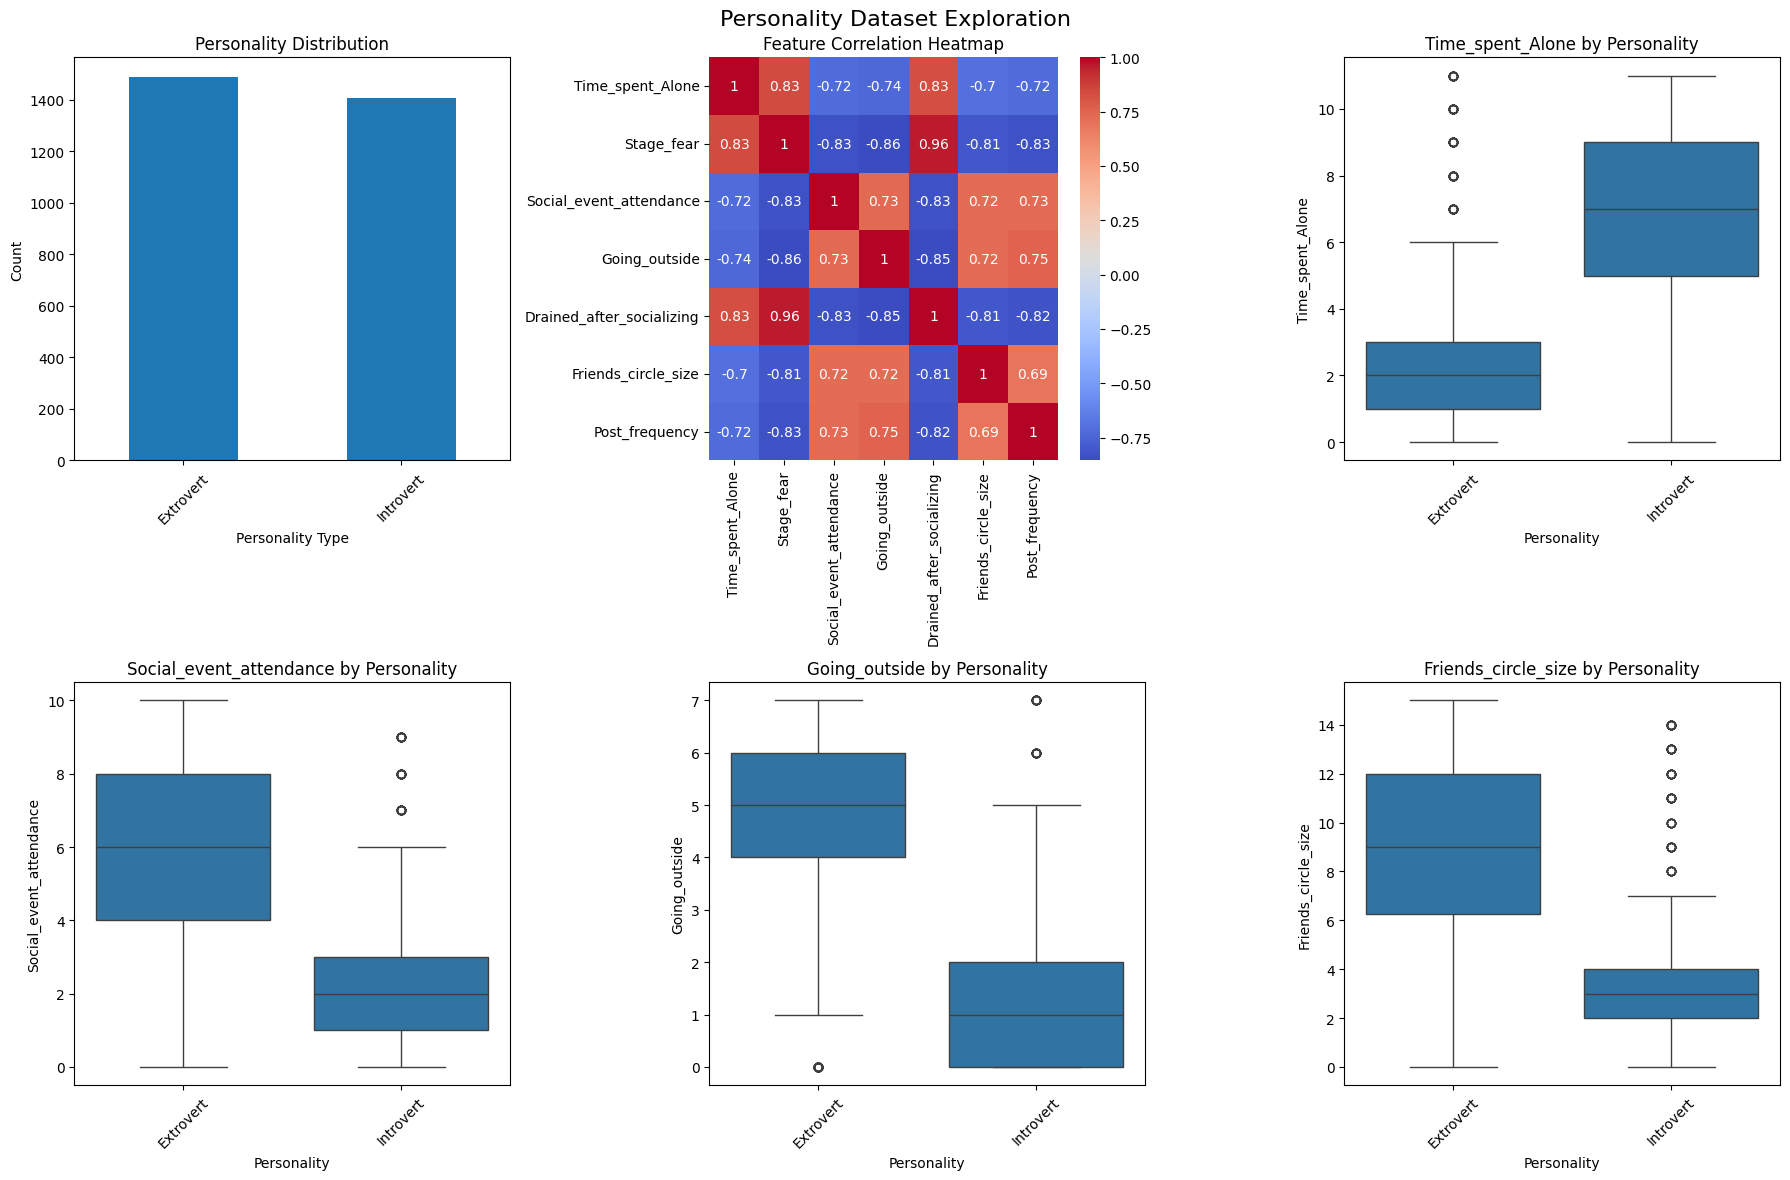

In [15]:
# Create data visualizations
fig = classifier.visualize_data()

In [16]:
# Train the model with hyperparameter tuning
model_results = classifier.train_best_model()


Training Random Forest model with hyperparameter tuning...
Searching for best parameters...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest - Best CV Score: 0.9388
Random Forest - Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}



Evaluating best model on test data...
Test Accuracy: 0.9155
Test AUC Score: 0.9548

Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.94      0.89      0.92       298
   Introvert       0.89      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



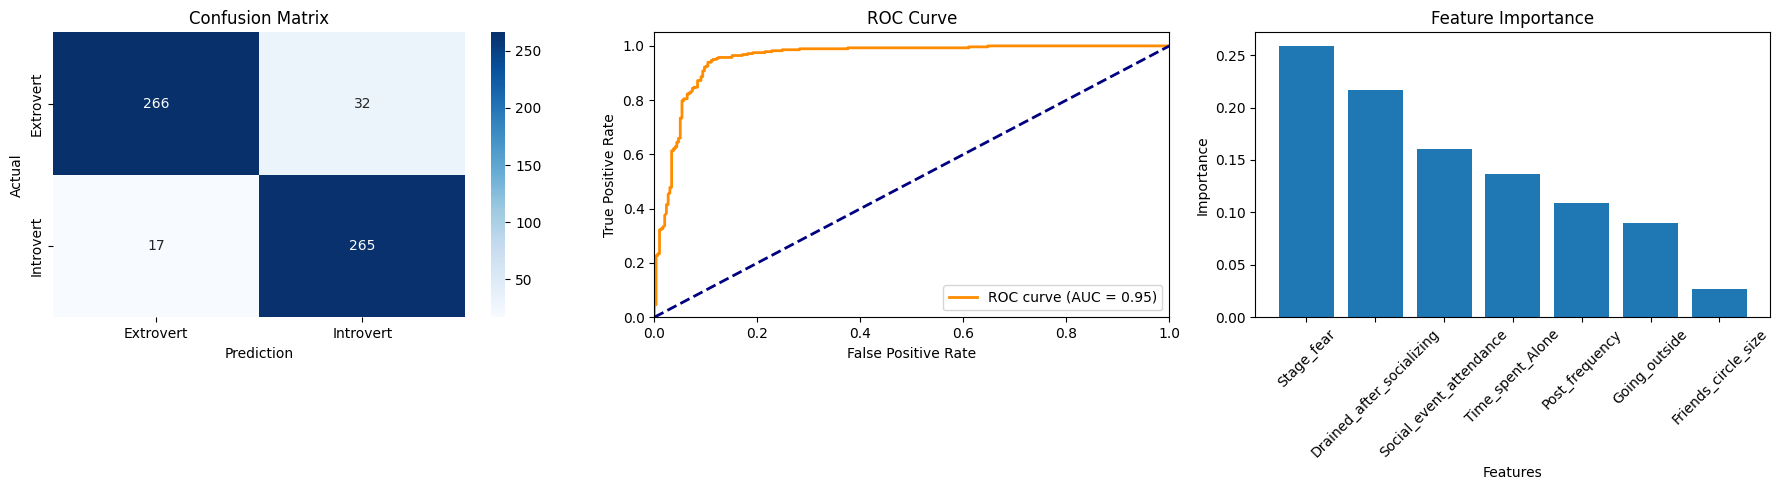


Model Results:
--------------------------------------------------
Random Forest: CV Score = 0.9388
Metrics saved to Results/metrics.txt


In [17]:
# Evaluate the model
accuracy, auc_score = classifier.evaluate_model(model_results)

In [18]:
# Save the model for deployment
classifier.save_model()


Saving model for deployment to Hugging Face Spaces...
✓ Model saved in skops format for Hugging Face Spaces
✓ Label encoder saved in skops format
✓ Feature names saved in skops format

Checking model security for deployment...
Unknown types required: []
Testing model loading...
✓ Model successfully loaded and ready for deployment!

FILES FOR HUGGING FACE SPACES DEPLOYMENT:
📁 Model/personality_classifier.skops     <- MAIN MODEL
📁 Model/label_encoder.skops             <- FOR DECODING RESULTS
📁 Model/feature_names.skops             <- FOR INPUT VALIDATION
📁 Results/metrics.txt                   <- PERFORMANCE METRICS
Use personality_classifier.skops as the main model in Hugging Face Spaces
